<a href="https://colab.research.google.com/github/komorimasashi/FacialCuteness_GPOR/blob/main/RegressionMethods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 線形回帰分析，LOESS，ガウス過程回帰の比較

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### データセットの作成

$f(x) = x \sin(x)$から20点サンプリングし観測ノイズとして正規ノイズが乗っているデータを考える

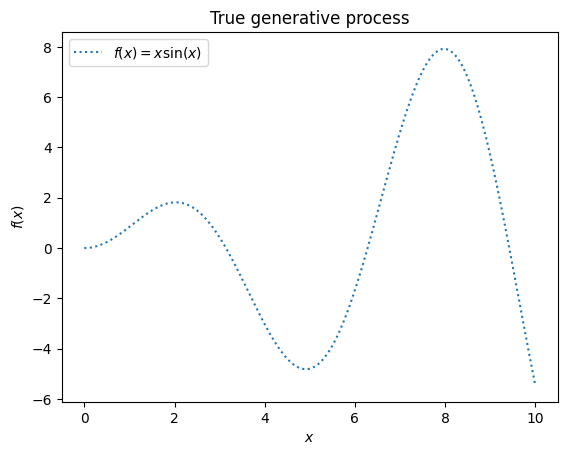

In [2]:
X = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

In [3]:
# サンプリングする
sample_size = 20
rng = np.random.RandomState(1234)
training_indices = rng.choice(np.arange(y.size), size=sample_size, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [4]:
# 観測誤差を加える
noise_std = 1
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

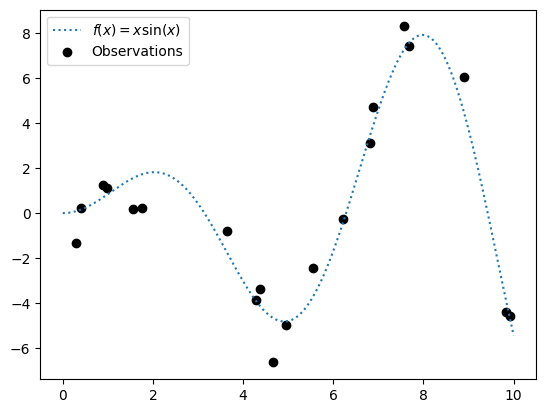

In [5]:
# 描画
X = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train_noisy, label="Observations",color="black")
plt.legend()

### 線形回帰分析

In [6]:
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression

In [7]:
# 回帰モデルの作成
X_train_with_const = sm.add_constant(X_train)
ols_model =  sm.OLS(y_train_noisy, X_train_with_const).fit()

# 予測と95%信頼区間
X_pred_with_const = sm.add_constant(X)
predictions = ols_model.get_prediction(X_pred_with_const)
conf_int = predictions.conf_int(alpha=0.05)
y_pred = predictions.predicted_mean

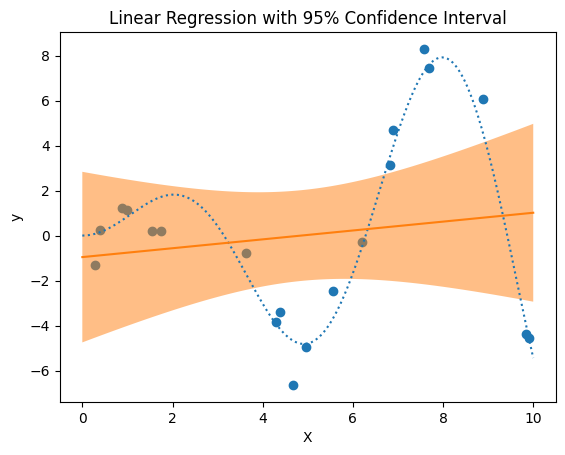

In [8]:

# 結果のプロット
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train_noisy, label="Observations")
plt.plot(X, y_pred, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    conf_int[:, 0],
    conf_int[:, 1],
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.title('Linear Regression with 95% Confidence Interval')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

### LOESS（局所回帰）

In [9]:
from statsmodels.nonparametric.smoothers_lowess import lowess

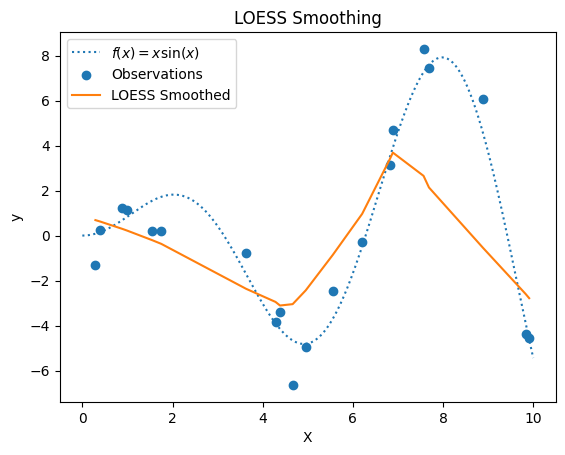

In [10]:
# LOESS
smoothed = lowess(y_train_noisy, X_train.squeeze(), frac=0.6)

# プロット
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train_noisy, label="Observations")
plt.plot(smoothed[:, 0], smoothed[:, 1], label='LOESS Smoothed')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('LOESS Smoothing')
plt.show()


### ガウス過程回帰分析

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [12]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp_noisy =  GaussianProcessRegressor(
    kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=9
)
gp_noisy.fit(X_train, y_train_noisy)

GaussianProcessRegressor(alpha=1, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=9)

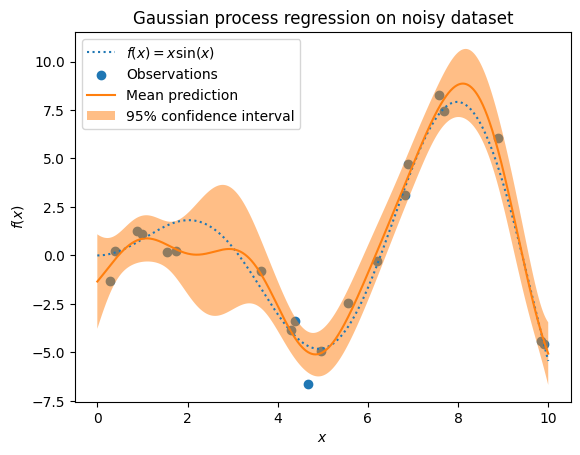

In [14]:
#  predictで予測平均と予測分散の平方根を求める
y_pred, sigma = gp_noisy.predict(X, return_std=True)

#描画
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train_noisy, label="Observations")
plt.plot(X, y_pred, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    y_pred - 1.96 * sigma,
    y_pred + 1.96 * sigma,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression")